In [441]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

In [185]:
path_to_data = 'ads_data.csv'
path_to_clients = 'ads_clients_data.csv'

In [289]:
ads_data = pd.read_csv(path_to_data, sep=',')

In [384]:
ads_clients = pd.read_csv(path_to_clients, sep=',')

In [188]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [190]:
ads_clients.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [191]:
# calculate the average number of different advertising events (views and clicks) on ads
ads_by_views_and_clicks = ads_data.groupby(['ad_id', 'event'], as_index=False) \
        .agg({'date': 'count', 'date': 'count'}) \
        .rename(columns={'date': 'count'})
ads_by_views_and_clicks.pivot(index='ad_id', columns='event', values='count').fillna(0).mean().round(0)

event
click    113.0
view     923.0
dtype: float64

C:\Users\avtut\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

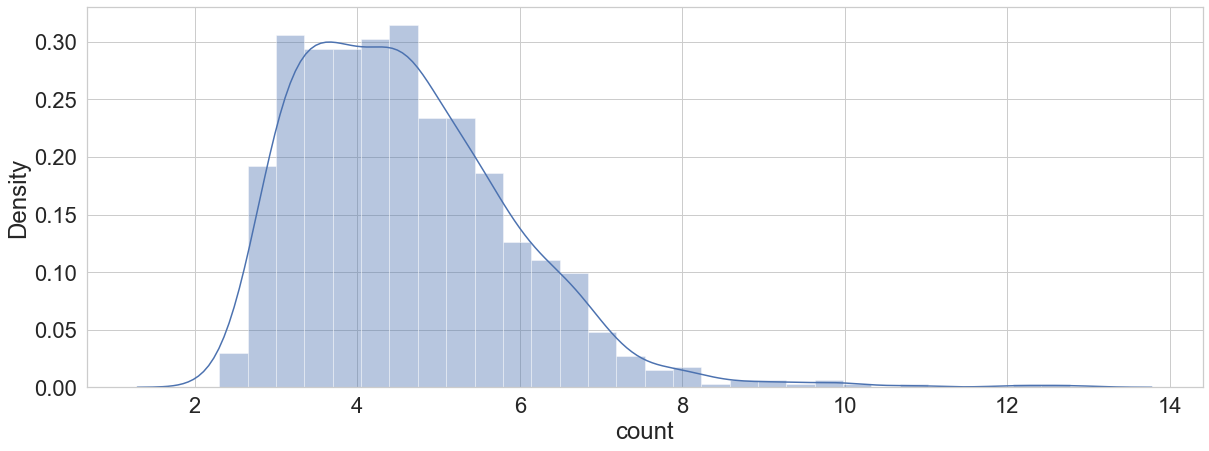

In [192]:
# look at the distribution of ad views
ads_views = ads_by_views_and_clicks.loc[ads_by_views_and_clicks.event == 'view'][['ad_id', 'count']]
ads_views_log = np.log(ads_views['count'])
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize': (20, 7)}
        )

sns.distplot(ads_views_log)

In [193]:
# find the average number of viewa per 1 ad (ad_id) by day, ignoring ads that had no views
# calculate the moving average of the result obtained with a window of 2 elements
# what is the value of the moving average for April 6, 2019?
ads_data.loc[ads_data.event == 'view'] \
        .groupby(['ad_id','date'], as_index=False) \
        .agg({'ad_id': 'count'}) \
        .groupby('date') \
        .agg({'ad_id':'mean'})['ad_id'].rolling(window=2).mean()['2019-04-06'].round(0)

598.0

<AxesSubplot:xlabel='date'>

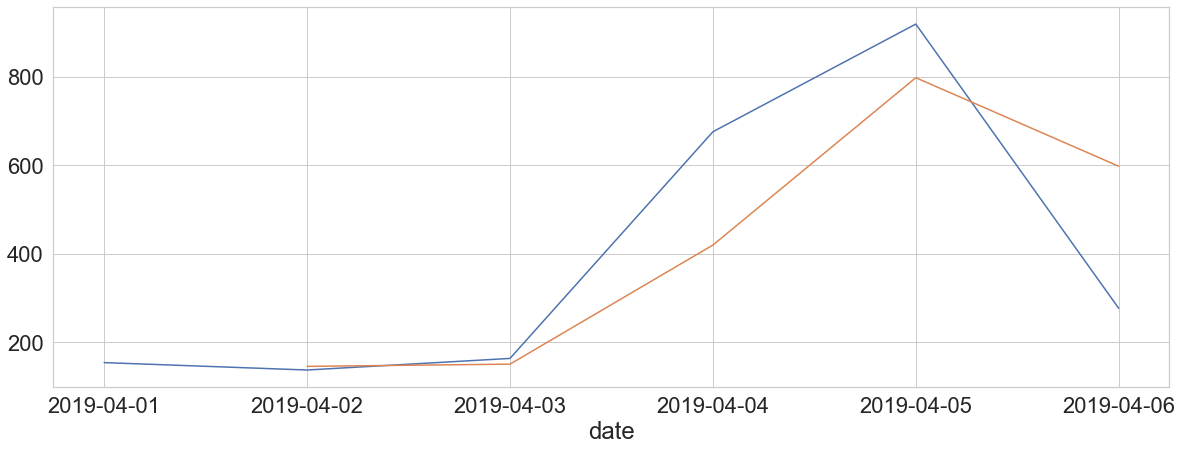

In [194]:
# plot on one chart the values of the average number of views by day and the moving average
views_by_days = ads_data.loc[ads_data.event == 'view'] \
            .pivot_table(index='ad_id', columns='date', values='time', aggfunc='count')
views_mean = views_by_days.mean()
views_mov_average = views_by_days.mean().rolling(window=2).mean().round(0)
sns.lineplot(data=views_mean)
sns.lineplot(data=views_mov_average)

In [414]:
# Calculate on which day there is the greatest difference in modulus between arithmetic averages and moving averages?
abs((views_mean - views_mov_average).dropna()).sort_values(ascending=False).head(1)

date
2019-04-06    320.877273
dtype: float64

In [415]:
# Combine ad data with ad customer data
df = ads_clients.merge(ads_data, on=['client_union_id'], how='inner', suffixes=['_client_date', '_ad_date'])

In [416]:
# find the average number of days from the date the ad client was created and the first time the ad was run by that client
df.date_ad_date  = pd.to_datetime(df.date_ad_date)
df.create_date = pd.to_datetime(df.create_date)
df['date_difference'] = df.date_ad_date - df.create_date
df.groupby('client_union_id').date_difference.min().mean()

Timedelta('124 days 09:04:43.532219570')

In [419]:
# number of unique clients
unique_clients = len(ads_clients.client_union_id.unique())

In [424]:
# Clients running ads
ran_ads_clients = df.groupby('client_union_id', as_index=False).date_difference.min()
# users who ran ads during the year
ads_clients_num= len(ran_ads_clients[ran_ads_clients .date_difference <= pd.Timedelta(365, unit='d')])
round((ads_clients_num / unique_clients) * 100, 2)

0.69

In [440]:
# Determine how many unique customers launched their first ad in their first month of existence (0 to 30 days)
list_of_intervals = pd.to_timedelta(['0d', '30d', '90d', '180d', '365d'])
ran_ads_clients['run_time'] = \
        pd.cut( \
               ran_ads_clients.date_difference,
               list_of_intervals,
               labels = ['month', 'quarter', 'half-year', 'year'])
len(ran_ads_clients[ran_ads_clients.run_time == 'month'])

11

In [445]:
# build an interactive barplot that will show categories with the number of unique customers in them
fig = px.bar(ran_ads_clients, x='run_time')
fig.show()